In [1]:
# library

import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm
from Baseline_func import *
from model import *

/home/jrkim/.conda/envs/intern/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting for detection

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

cfg = {
    'img_size':512,
    'hidden_size':48,
    'learning_rate':0.0001,
    'num_epochs':100,
    'batch_size':24,
    'seed':30,
    'save_interval':10
}
seed_everything(cfg['seed'])
# data load
train_dataset = CustomDataset('./train', True, get_train_transforms(cfg['img_size'], 0.001), pad=150)
train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, collate_fn=collate_fn)
!nvidia-smi

device : cuda
Current : 0
Count : 1
Tue May 30 22:38:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   41C    P0    62W / 300W |  22467MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 O

In [3]:
# build dector model
# https://hyungjobyun.github.io/machinelearning/FasterRCNN2/
def custom_model(img_size, hidden_size, num_layers,
                anchor_sizes=((64,128,256),), anchor_scales=((0.7, 1.0, 1.5),), 
                pooling_out_size=7, pooling_sampling_ratio=2,
                state_path = None):
    
    pretrain = Classifier(img_size, hidden_size, num_layers, num_classes=34)
    state = torch.load(state_path)
    pretrain.load_state_dict(state['model'])
    feature = pretrain.featuremap
    anchor_gen = AnchorGenerator(anchor_sizes, anchor_scales)
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=pooling_out_size,
                                                    sampling_ratio=pooling_sampling_ratio)
    box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= feature.out_channels*(pooling_out_size**2),
                                                                   representation_size=512) 
    box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(512, num_classes=35)
    model = torchvision.models.detection.FasterRCNN(backbone=feature, num_classes=None, min_size=500, max_size=1000,
                                                    rpn_anchor_generator=anchor_gen, box_predictor=box_predictor,
                                                    box_roi_pool=roi_pooler, box_head=box_head,
                                                    rpn_pre_nms_top_n_train=4000, rpn_pre_nms_top_n_test=4000,
                                                    rpn_post_nms_top_n_train=1300, rpn_post_nms_top_n_test=300,
                                                    rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                                                    rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                                                    box_score_thresh=0.3, box_nms_thresh=0.7, box_detections_per_img=300,
                                                    box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                                                    box_batch_size_per_image=64, box_positive_fraction=0.5)
    return model

In [4]:
# model, optimizer, scheduler for detector

model = custom_model(cfg['img_size'], cfg['hidden_size'], num_layers=[4,4,18,4],
                     anchor_sizes=((100,200,300),), anchor_scales=((0.7, 1.0, 1.5),), 
                     pooling_out_size=7, pooling_sampling_ratio=2, state_path = './model_saves/model1_90')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['num_epochs'])

In [19]:
img, tar = next(iter(train_loader))
tar = [{k: v.to(device) for k, v in t.items()} for t in tar]
img = img.to(device)
model.train()
out = model(img, tar)
out

In [ ]:
# training
# kill process
# kill -9 PID_number

train(model, train_loader, optimizer, scheduler, 
      save_interval=cfg['save_interval'], num_epochs=cfg['num_epochs'],
      state_path=None, model_name='model1D', device=device)

In [57]:
##########
# inference function
##########
def inference(model, test_loader, device, title, score_threshold, img_size):
    model.eval()
    model.to(device)
    
    results = pd.read_csv('./sample_submission.csv')

    for img_files, images, img_width, img_height in tqdm(iter(test_loader)):
        images = [img.to(device) for img in images]

        with torch.no_grad():
            outputs = model(images)

        for idx, output in enumerate(outputs):
            boxes = output["boxes"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            for box, label, score in zip(boxes, labels, scores):
                if score >= score_threshold:
                    x1, y1, x2, y2 = box
                    x1, y1, x2, y2 = box_denormalize(x1, y1, x2, y2, 
                                                     img_width[idx], 
                                                     img_height[idx], img_size)
                    new = pd.DataFrame({
                        'file_name':[img_files[idx]],
                        'class_id':[label-1],
                        'confidence':[score],
                        'point1_x':[x1], 'point1_y':[y1],
                        'point2_x':[x2], 'point2_y':[y1],
                        'point3_x':[x2], 'point3_y':[y2],
                        'point4_x':[x1], 'point4_y':[y2]})
                    results = pd.concat([results, new], ignore_index=True, axis=0)
    # 결과를 CSV 파일로 저장
    results.to_csv(title, index=False)
    print('Done.')
    
test_dataset = CustomDataset('./test', False, get_test_transforms(cfg['img_size']), None)
test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False)

# load
state = torch.load('./model_saves/model1D_20')
model.load_state_dict(state['model'])

inference(model, test_loader, device, title='./result_saves/model1D_20epoch.csv', score_threshold=0, img_size=cfg['img_size'])


100%|██████████| 142/142 [05:42<00:00,  2.42s/it]


Done.


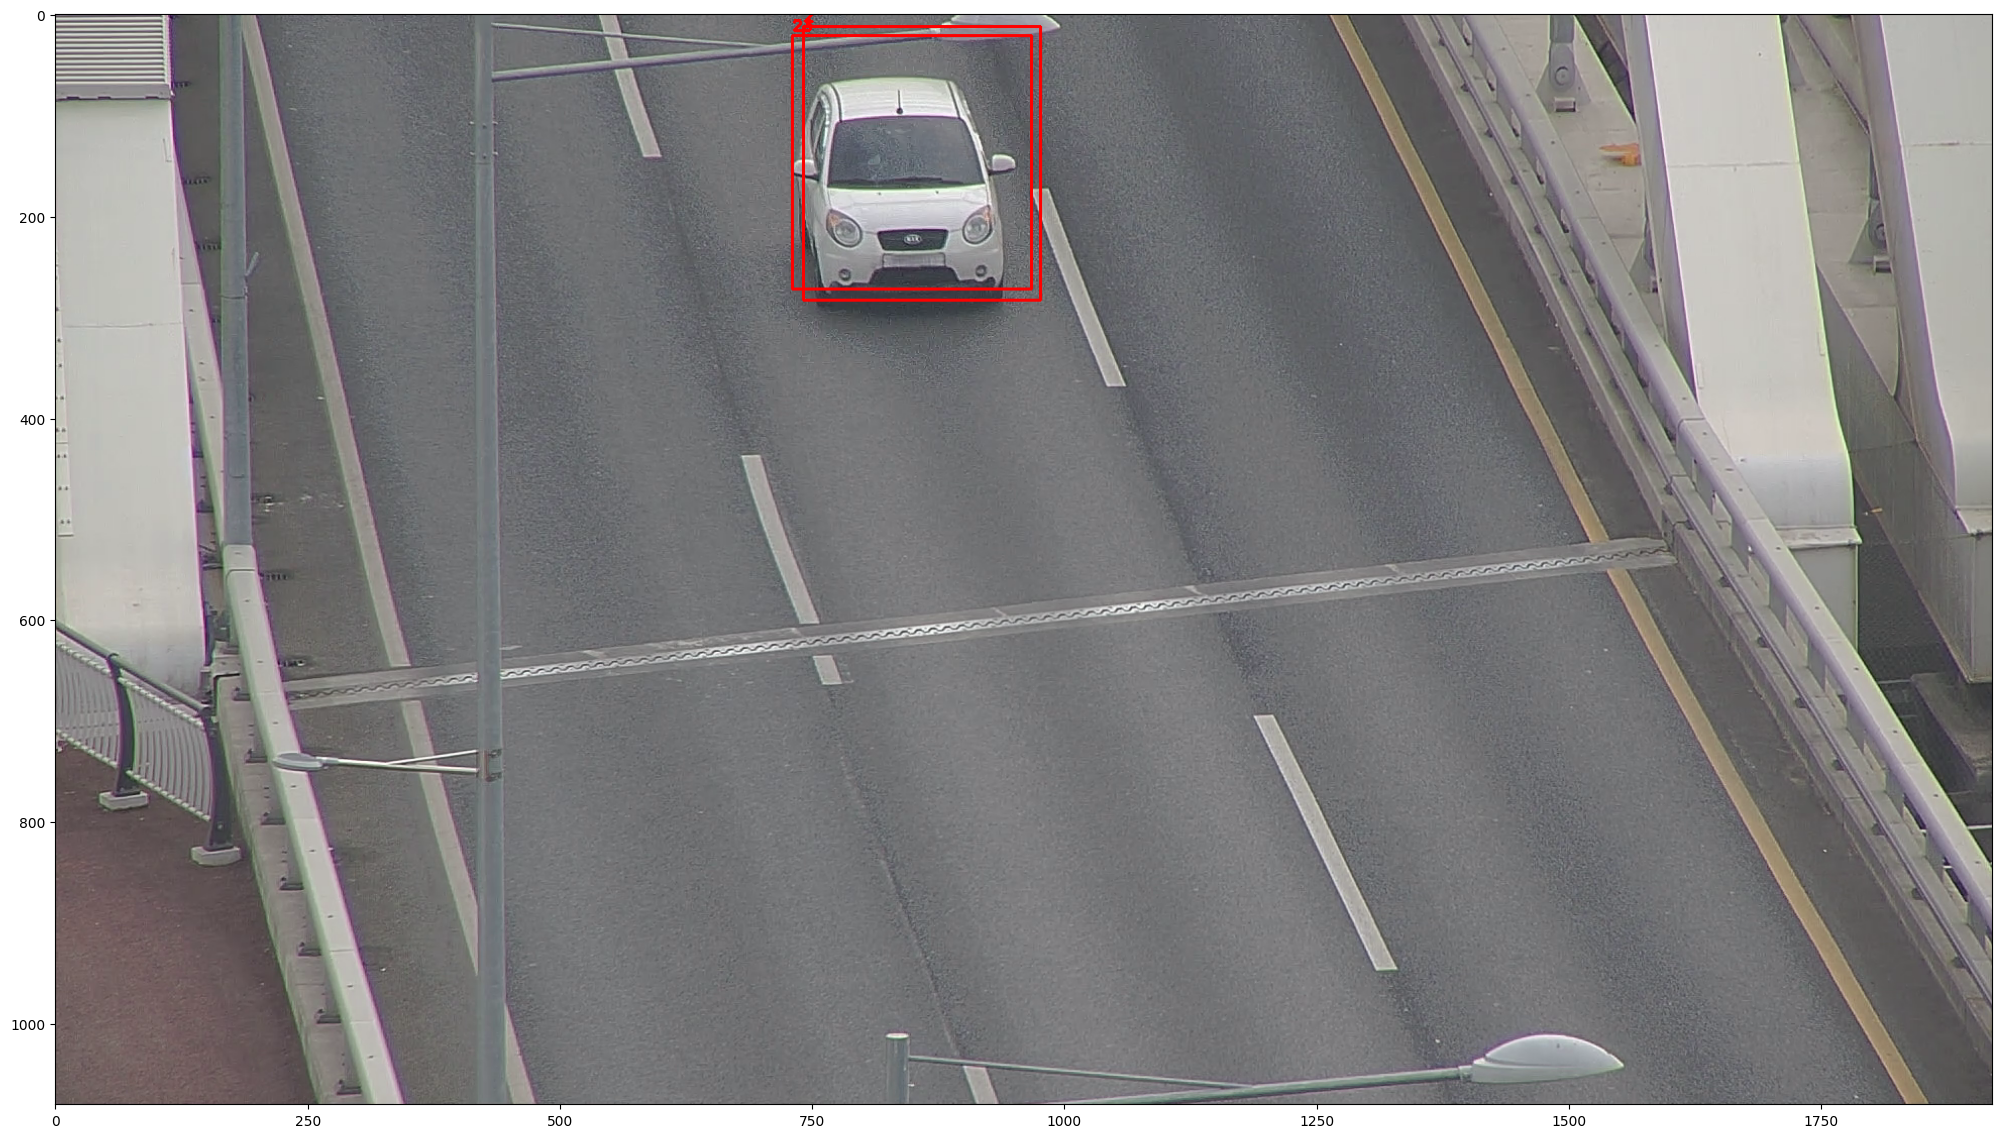

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
1477,103230249.png,23,0.445504,730.107544,21.418354,966.900574,21.418354,966.900574,271.557220,730.107544,271.557220
1478,103230249.png,2,0.439781,740.693481,11.646140,975.545166,11.646140,975.545166,283.397644,740.693481,283.397644


In [15]:
model_result = pd.read_csv('./result_saves/model1D_20epoch.csv')
file_list = model_result.file_name.unique()

idx = 777
draw_image_tset(file_list[idx], model_result)
model_result.loc[model_result.file_name==file_list[idx]]

In [6]:
model_result.shape

(6781, 11)

In [7]:
model_result.describe()

,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
count,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000,6781.000000
mean,11.297596,0.722556,857.377927,313.681437,1183.897854,313.681437,1183.897854,606.758552,857.377927,606.758552
std,10.948400,0.240721,308.216846,218.197044,313.638252,218.197044,313.638252,248.361242,308.216846,248.361242
min,0.000000,0.300062,0.000000,0.000000,139.840378,0.000000,139.840378,119.968842,0.000000,119.968842
25%,2.000000,0.495191,684.142883,119.592705,968.814819,119.592705,968.814819,388.541840,684.142883,388.541840
50%,6.000000,0.770977,829.678040,293.902222,1160.526855,293.902222,1160.526855,601.141052,829.678040,601.141052
75%,23.000000,0.965619,1116.581543,491.642426,1442.498535,491.642426,1442.498535,799.678040,1116.581543,799.678040
max,33.000000,0.999992,1566.991821,947.227356,1920.000000,947.227356,1920.000000,1080.000000,1566.991821,1080.000000
